In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from skimage.transform import resize
from keras.preprocessing import image
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.models import Model, Sequential, load_model
from keras import backend as K
from keras.layers import *

from sklearn.cluster import DBSCAN
from sklearn.neighbors import KDTree

from PIL import Image

%matplotlib inline

Using TensorFlow backend.


### Motivation

The "normal" (class 0) observations were generated from tiles of the original DDSM images, and so include a number of instances of chart annotations of the following sort found in the image background:

In [2]:
def plot_img_from_file(filename, ax, title=None):
    img = plt.imread(filename)
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    if title is not None: 
        ax.set_title(title)

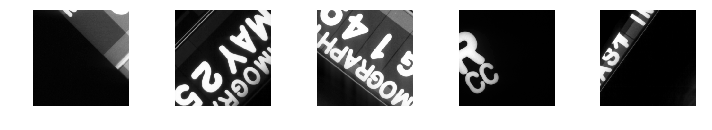

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10,15))
axes = axes.ravel()
for ax, file in zip(axes, ['c311.png', 'c545.png', 'c578.png', 'c596.png', 'c1191.png']):
    plot_img_from_file(f"data/train_images/{file}", ax)
fig.tight_layout()

While it was easy to remove uninformative observations that were mostly or entirely black based on the distribution of pixel intensities in the images, this approach was unsuccessful at sorting out observations with the sort of "misinformative" content shown above. Because these images contained positive content that would be easy for a CNN to recognize, and because only the normal-class images contained this type of content, we feared that the classifier would learn to associate annotative lettering with normal-class observations. The trained model would therefore perform poorly when used to classify the full images, in which chart annotations were not uncommon even in scans that contain abnormalities (masses or calcifications).

We decided to try to use a model to automate the process of identifying these "misinformative" images from the set of all normal-class observations. Since we did not have a large set of scans with lettering to use for training the model in a supervised fashion, we instead had to adopt an unsupervised method for identifying these images. We therefore trained an autoencoder on the normal images, expecting that it would identify the latent characteristics of the text annotations that we ourselves could recognize by sight. We then performed unsupervised clustering in the learned latent space to identify clusters of observations with these types of features.

---

### Load class 0 ("normal") images

In [4]:
'''IMPORT TRAINING LABELS'''
train_data_c0_df = pd.read_csv('data/training_data.csv')
train_data_c0_df = train_data_c0_df.loc[train_data_c0_df['class']==0,:]
train_data_c0_df = train_data_c0_df.drop(columns=['normal_class','class','Unnamed: 0'])
train_data_c0_df['filename'] = train_data_c0_df['id'].apply(lambda x: x+'.png')

In [5]:
'''IMPORT TEST LABELS'''
test_data_c0_df = pd.read_csv('data/test_data.csv')
test_data_c0_df = test_data_c0_df.loc[test_data_c0_df['class']==0,:]
test_data_c0_df['filename'] = test_data_c0_df['id'].apply(lambda x: x+'.png')

### Build and fit autoencoder

**Encoder**

In [6]:
latent_dim = 150
img_dims = (128,128,3)

input_img = Input(shape=img_dims)

x = Conv2D(128, (3,3), padding='same', use_bias=False)(input_img)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(32, (3,3), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D((2,2))(x)
shape_before_flattening = K.int_shape(x)
x = Flatten()(x)
x = Dense(256)(x)
z = Dense(latent_dim, activation='relu')(x)

encoder = Model(input_img, z)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     3456      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 128)     512       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 128)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        73728     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 64)        256       
__________

**Decoder**

In [7]:
decoder_input = Input(K.int_shape(z)[1:])

x = Dense(256)(decoder_input)
x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(x)
x = Reshape(shape_before_flattening[1:])(x)
x = UpSampling2D((2,2))(x)
x = Conv2DTranspose(32, (3,3), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = UpSampling2D((2,2))(x)
x = Conv2DTranspose(64, (3,3), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = UpSampling2D((2,2))(x)
x = Conv2DTranspose(128, (3,3), padding='same', activation='relu')(x)

decoder_output = Conv2D(3, 1, activation='sigmoid')(x)

decoder = Model(decoder_input, decoder_output)
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               38656     
_________________________________________________________________
dense_4 (Dense)              (None, 8192)              2105344   
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 32)        0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 32)        9216      
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 32)        128       
__________

**Autoencoder**

In [8]:
ae_out = decoder(encoder(input_img))

ae = Model(input_img, ae_out)
ae.compile(optimizer='adam', loss='binary_crossentropy')
ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
model_1 (Model)              (None, 150)               2232470   
_________________________________________________________________
model_2 (Model)              (None, 128, 128, 3)       2246275   
Total params: 4,478,745
Trainable params: 4,478,105
Non-trainable params: 640
_________________________________________________________________


In [9]:
batch_size = 128
epochs = 30
steps_per_epoch = int(np.ceil(len(train_data_c0_df) / batch_size))
validation_steps = int(np.ceil(len(test_data_c0_df) / batch_size))

In [10]:
train_datagen = image.ImageDataGenerator(rescale=1./255)
test_datagen = image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        directory='data/train_images',
        dataframe=train_data_c0_df,
        x_col="filename",
        batch_size=batch_size,
        class_mode="input",  
        target_size=img_dims[:2],
        color_mode="rgb",
        shuffle=True,
        seed=42
)

test_generator = test_datagen.flow_from_dataframe(
        directory='data/test_images',
        dataframe=test_data_c0_df,
        x_col="filename",
        batch_size=batch_size,
        class_mode="input",  
        target_size=img_dims[:2],
        color_mode="rgb",
        shuffle=True,
        seed=42
)    

Found 48596 images.
Found 13360 images.


In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')

history = ae.fit_generator(train_generator, 
                        steps_per_epoch=steps_per_epoch, 
                        epochs=epochs, 
                        verbose=1, 
                        callbacks=[early_stopping], 
                        validation_data=test_generator, 
                        validation_steps=validation_steps)

Epoch 1/30
380/380 [==============================] - 496s 1s/step - loss: 0.5609 - val_loss: 0.5560
Epoch 2/30
380/380 [==============================] - 479s 1s/step - loss: 0.5567 - val_loss: 0.5546
Epoch 3/30
380/380 [==============================] - 478s 1s/step - loss: 0.5561 - val_loss: 0.5628
Epoch 4/30
380/380 [==============================] - 478s 1s/step - loss: 0.5558 - val_loss: 0.5544
Epoch 5/30
380/380 [==============================] - 476s 1s/step - loss: 0.5556 - val_loss: 0.5563
Epoch 6/30
380/380 [==============================] - 478s 1s/step - loss: 0.5553 - val_loss: 0.5543
Epoch 7/30
380/380 [==============================] - 476s 1s/step - loss: 0.5552 - val_loss: 0.5537
Epoch 8/30
380/380 [==============================] - 478s 1s/step - loss: 0.5552 - val_loss: 0.5565
Epoch 9/30
380/380 [==============================] - 476s 1s/step - loss: 0.5551 - val_loss: 0.5531
Epoch 10/30
380/380 [==============================] - 477s 1s/step - loss: 0.5549 - val_lo

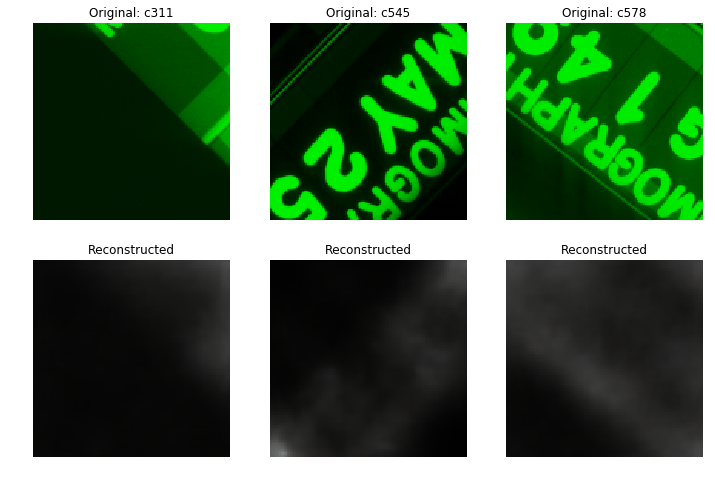

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,8))

for i, imgnum in enumerate(['c311', 'c545', 'c578']):
    filepath = f"data/train_images/{imgnum}.png"
    img = plt.imread(filepath)
    img = resize(img, img_dims, mode='constant')

    axes[0,i].imshow(img)
    axes[0,i].set_title(f"Original: {imgnum}")
    axes[0,i].axis('off')

    # Map original image into the latent space
    img_encoded = encoder.predict(np.array([img]))
    img_decoded = decoder.predict(img_encoded)[0]
    axes[1,i].imshow(img_decoded)
    axes[1,i].set_title("Reconstructed")
    axes[1,i].axis('off');

The reconstructed images passed through the autoencoder only vaguely resemble the original images, potentially suggesting that the model was unable to learn to identify the alphanumeric annotations as conceptually distinct from the desired content (breast tissue). We also trained several Variational Autoencoder models, though they performed no better than this vanilla autoencoder.

### Map the original images into the learned latent feature space

In [57]:
encodings = []
ids = []
idx = []
for row in train_data_c0_df.iterrows():
    idx.append(row[0])
    ids.append(row[1]['id'])
    filepath = "data/train_images/" + row[1]['filename']
    img = plt.imread(filepath)
    img = resize(img, img_dims, mode='constant')
    encodings.append(encoder.predict(np.array([img])).squeeze().tolist())

In [58]:
# prepare DataFrame with latent feature values for each image in the training set
encodings_df = pd.DataFrame({'idx':idx, 'id':ids, 'encodings':encodings}).set_index('idx')
encodings_df = train_data_c0_df.merge(encodings_df, left_index=True, right_index=True)
encodings_df = encodings_df.drop(columns='id_y')

encodings_feats = encodings_df['encodings'].apply(pd.Series)
encodings_feats = encodings_feats.rename(columns = lambda x : 'latentvar_' + str(x+1))
encodings_df = encodings_df.merge(encodings_feats, left_index=True, right_index=True)

### Cluster analysis

In [67]:
latentvar_cols = [col for col in encodings_df.columns if col.startswith('latentvar_')]
X = encodings_df[latentvar_cols].copy()
y = encodings_df['id_x'].copy()

X = StandardScaler().fit_transform(X)

#### DBSCAN

We first use DBSCAN to identify similar observations to the five displayed above. Since we do not know the shape of the latent feature space, and do not even roughly know the number of observations that only contain annotation text (i.e. that should be removed), DBSCAN is an ideal clustering algorithm in that it does not require that we specify the number of clusters in advance, and does not impose assumptions on the shape of the clusters. 

Using the default parameters, the DBSCAN algorithm identifies all five observations as "noisy" (not belonging to a cluster). We therefore increased the maximum distance between samples for them to be considered in the same neighborhood, though obtained the same result.

In [83]:
dbscan_results = DBSCAN(eps=0.9).fit(X)

In [84]:
# distribution of cluster membership (-1 represents "noisy" observations)
pd.Series(dbscan_results.labels_).value_counts()

-1      35617
 0      11043
 1       1023
 2        214
 13        25
 3         20
 5         19
 36        17
 32        14
 48        14
 18        14
 37        14
 33        14
 52        14
 57        12
 89        11
 53        11
 28        11
 46        10
 35        10
 25         9
 47         9
 7          9
 30         9
 50         8
 12         8
 40         8
 78         8
 39         8
 20         8
        ...  
 29         5
 60         5
 27         5
 58         5
 26         5
 88         5
 56         5
 24         5
 55         5
 23         5
 15         5
 17         5
 44         5
 51         5
 82         5
 49         5
 75         5
 16         5
 14         5
 77         5
 45         5
 76         5
 54         4
 86         4
 83         4
 81         4
 79         4
 100        3
 43         3
 42         3
Length: 102, dtype: int64

In [85]:
dbscan_df = pd.DataFrame({'img_id': y, 'cluster_id': dbscan_results.labels_})
dbscan_df[dbscan_df['img_id'].isin(['c311', 'c545', 'c578', 'c596', 'c1191'])]

,img_id,cluster_id
310,c311,-1
544,c545,-1
577,c578,-1
595,c596,-1
1190,c1191,-1


#### k nearest neighbors

Since DBSCAN identified all of the observations as not belonging to a neighborhood, we instead tried finding the k nearest neighbors in latent space to each of the original observations using a k-dimensional tree. However, the results confirm that the observations do not appear to cluster with other observations that are in any way similar.

In [86]:
kdt = KDTree(X, metric='euclidean')

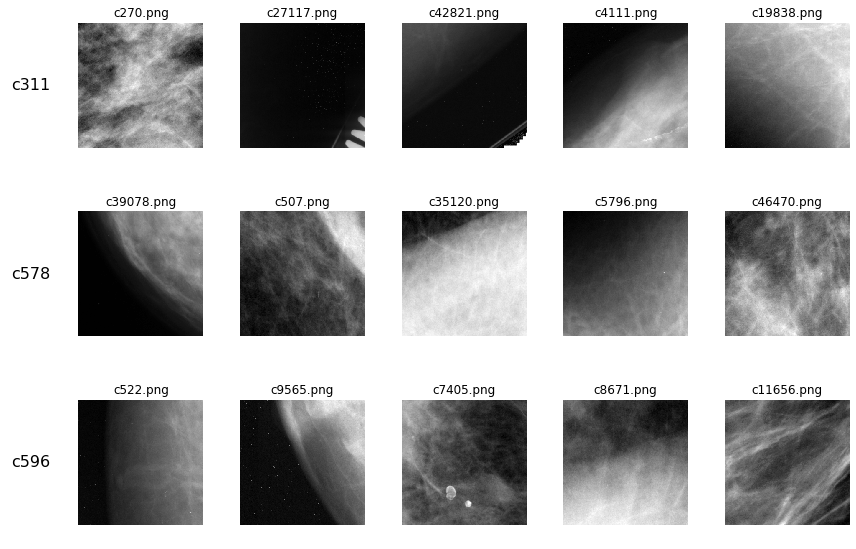

In [110]:
# get k nearest neighbors to each original image
K = 5
orig_imgs = ['c311', 'c578', 'c596']

fig, axes = plt.subplots(nrows=len(orig_imgs), ncols=K, figsize=(12,8))

for i, orig_img in enumerate(orig_imgs):
    dists, idxs = kdt.query(X[encodings_df['id_x']==orig_img,:], k=K)
    nbr_imgs = encodings_df.loc[idxs.squeeze(),'filename'].tolist()
    for j, imgfile in enumerate(nbr_imgs):    
        plot_img_from_file(f"data/train_images/{imgfile}", axes[i,j], f"{imgfile}")
        
for ax, row in zip(axes[:,0], orig_imgs):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad+2, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                fontsize=16, ha='right', va='center')

fig.tight_layout()   